*Unresolved Questions*
1. How `Regularization` Works in Neural Networks
2. Why `Regularization` is not sutaible with using `Adam Optimizer`?
---

### How Regularization Works in NN: A Two-Layer Network

Let's imagine we have a very simple network for a binary classification task:

*   **Layer 1 (Dense, 5 units):** We apply **L2 regularization** with `λ = 0.01`.
*   **Layer 2 (Dense, 1 unit, output):** We apply **L1 regularization** with `λ = 0.1`.
*   **Loss function:** Binary Crossentropy.

Let's say the weights for Layer 1 are `W1 = [w11, w12, ..., w15]` and for Layer 2 are `W2 = [w21]`.

**The total loss `L_total` that the optimizer tries to minimize is:**

`L_total = L_cross_entropy + Ω_Layer1 + Ω_Layer2`

**Now, let's plug in the formulas:**

1.  **Layer 1's Penalty (L2):**
    `Ω_Layer1 = (0.01 / 2) * (w11² + w12² + ... + w15²)`

2.  **Layer 2's Penalty (L1):**
    `Ω_Layer2 = 0.1 * |w21|`  *(just the absolute value of its single weight)*

3.  **Therefore, the complete loss is:**
    `L_total = L_cross_entropy + [ (0.01 / 2) * ||W1||² ] + [ 0.1 * |w21| ]`

### What Does This Mean For Training?

During backpropagation, the optimizer calculates the gradient of `L_total` with respect to every weight.

*   **For a weight in Layer 1 (e.g., `w11`):**
    The gradient has two parts:
    `∂L_total/∂w11 = ∂L_cross_entropy/∂w11 + ∂Ω_Layer1/∂w11`
    Since we used L2, `∂Ω_Layer1/∂w11 = (0.01 / 2) * 2 * w11 = 0.01 * w11`
    So, the update will **shrink `w11`** by an amount proportional to its own value. Large weights are shrunk more.

*   **For the weight in Layer 2 (`w21`):**
    The gradient is:
    `∂L_total/∂w21 = ∂L_cross_entropy/∂w21 + ∂Ω_Layer2/∂w21`
    Since we used L1, `∂Ω_Layer2/∂w21 = 0.1 * sign(w21)` (where `sign(w21)` is +1 if positive, -1 if negative).
    So, the update will **push `w21` towards zero** by a constant amount (0.1), regardless of its value. This often leads to exactly zero weights (sparsity).

### Summary

| Layer | Regularization Type | Its Contribution to Total Loss (`Ω`) | Effect during Gradient Update |
| :--- | :--- | :--- | :--- |
| Layer 1 | L2 (λ=0.01) | `(0.01/2) * (sum of its weights²)` | Shrinks each weight by `0.01 * weight` |
| Layer 2 | L1 (λ=0.1) | `0.1 * (sum of absolute weights)` | Shrinks each weight by `0.1 * sign(weight)` |
| **Total** | - | **`L_original + Ω_Layer1 + Ω_Layer2`** | The optimizer minimizes this entire sum. |

So, the final loss is a global function, but it is composed of distinct, localized penalty terms that depend entirely on the regularization strategy you defined for each individual layer.

In [1]:
# Forming and Splitting Dataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(
    n_samples = 200,
    noise = 0.3,
    random_state = 42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

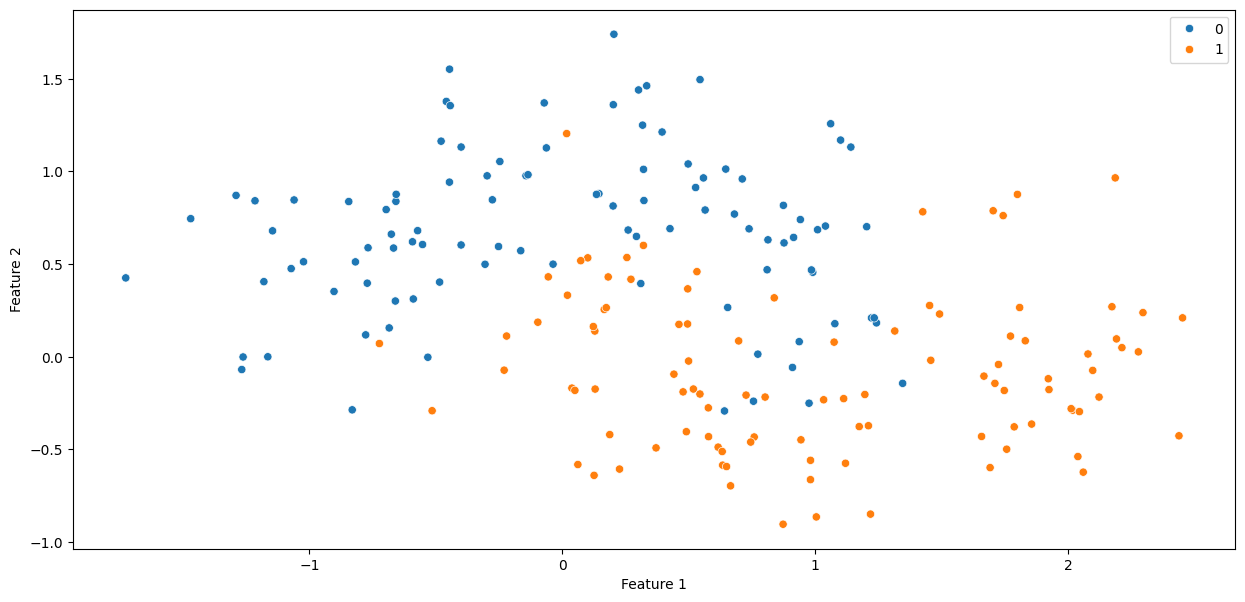

In [2]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (15, 7))
sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

ElasticNet Regularization: Use `keras.regularizers.l1_l2(l1=l1_value, l2=l2_value)` to combine L1 and L2 penalties (ElasticNet).

In [ ]:
# Building the model
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense

model = Sequential([
    Input(shape = (X_train.shape[1],)),
    Dense(units = 128, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01), kernel_initializer="he_normal"),
    Dense(units = 64, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01), kernel_initializer="he_normal"),
    Dense(units = 32, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01), kernel_initializer="he_normal"),
    Dense(units = 1, activation = 'sigmoid')
]) # I used l1_l2 which terrabely underfitted even for l1_norm = 0.01, on the other hand the error curve of both training and validation becomes smooth and very close to each other in the case of L2 Regularization

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,753 (42.00 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# To decrease the redundency of creating same layers multiple times you can do something like below
from functools import partial

RegularizedDense = partial(
    Dense,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_regularizer=keras.regularizers.l2(0.01)
)

model = tf.keras.Sequential([
    Input(shape = (X_train.shape[1],)),
    RegularizedDense(128),
    RegularizedDense(64),
    RegularizedDense(32),
    RegularizedDense(1, activation="softmax")
])

`L2 regularization` is fine when using `SGD`, `momentum optimization`, and `Nesterov momentum optimization`, but not with `Adam` and `its variants`. If you want to use `Adam with weight decay`, then do not use L2 regularization: `use AdamW` instead.

In [4]:
# Model Compiling and Training
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    optimizer = opt,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(X_train, y_train, epochs = 250, verbose = 0, validation_data = (X_test, y_test))

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step


Text(0.5, 1.0, 'Decision Boundry')

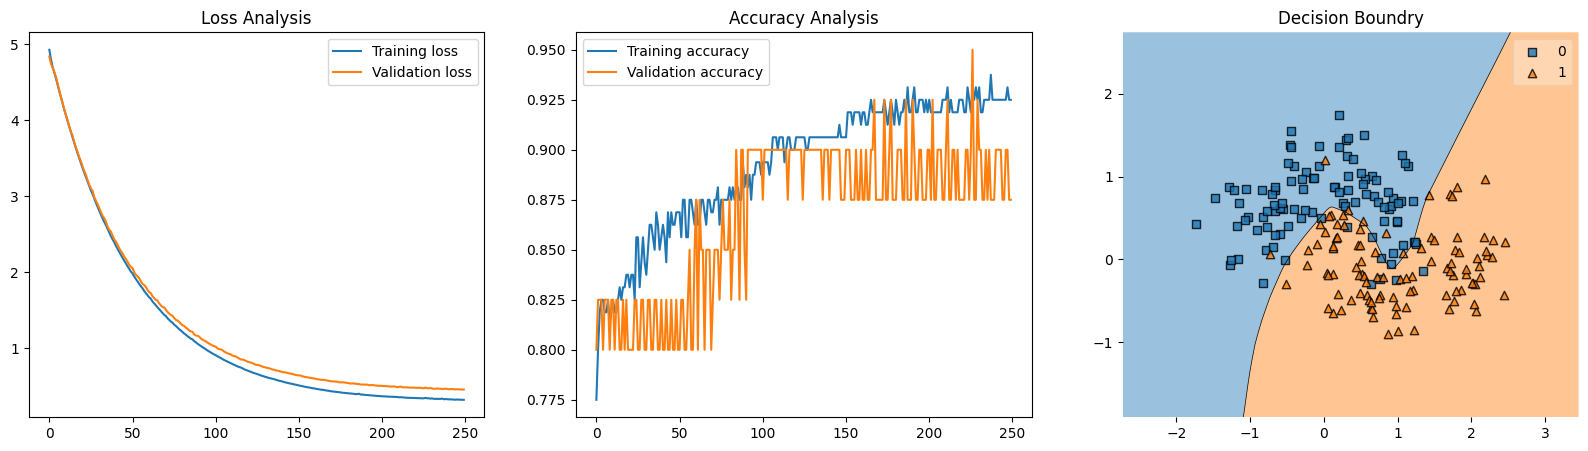

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

ax[0].plot(history.history['loss'], label = 'Training loss')
ax[0].plot(history.history['val_loss'], label = 'Validation loss')
ax[0].set_title('Loss Analysis')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label = 'Training accuracy')
ax[1].plot(history.history['val_accuracy'], label = 'Validation accuracy')
ax[1].set_title('Accuracy Analysis')
ax[1].legend()

# Plotting Decision Boundry
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(
    X = X, y = y, clf = model, ax = ax[2]
)
ax[2].set_title('Decision Boundry')

### The Core Problem: Adam "Breaks" the Classic Equivalence

In classic Stochastic Gradient Descent (SGD), **L2 regularization and weight decay are exactly equivalent.**

*   **L2 Regularization:** Adds a penalty term to the loss function: `Loss_new = Loss_original + (λ/2) * ||w||²`. The gradient of this penalty term is `λ * w`.
*   **Weight Decay:** Explicitly shrinks the weights by a factor `(1 - η*λ)` at each step: `w = w - η * ∇Loss - η * λ * w`.

In SGD, these two operations result in the **exact same update equation.** This is why the terms are often used interchangeably.

**However, this equivalence breaks completely with adaptive gradient algorithms like Adam, RMSProp, etc.** Here's why:

### 1. How Adam Works (The Short Version)

Adam doesn't just use the gradient `g_t`. It calculates two moment vectors:
1.  **First Moment (m_t):** An exponentially decaying average of past gradients (like momentum).
2.  **Second Moment (v_t):** An exponentially decaying average of past *squared* gradients (this estimates the variance/unsteadiness of each parameter).

The update rule for a parameter `w` at time `t` is:
`w_t = w_{t-1} - η * ( m_hat_t / (√v_hat_t + ε) )`

The key is that the update is **normalized** by `√v_hat_t`. Parameters with large, noisy gradients (high variance) get a smaller effective learning rate, while parameters with steady, small gradients get a larger effective learning rate.

### 2. Why L2 Regularization Fails with Adam

When you add L2 regularization to the loss function, the gradient Adam sees becomes:
`g_t = ∇Loss + λ * w`

This `g_t` is now used to calculate **both moments** `m_t` and `v_t`. This is the critical mistake.

*   **It corrupts the adaptive learning rate:** The `v_t` term, which is supposed to measure the variance of the *true* gradient `∇Loss`, now also includes the regularization term `λ * w`. This regularization penalty is not a stochastic gradient; it's a deterministic, weight-dependent term. By feeding it into `v_t`, you distort Adam's careful tuning of the per-parameter learning rate.
*   **The decay becomes adaptive (and wrong):** The amount of weight decay applied to each parameter is now scaled by `1 / √v_hat_t`. This means:
    *   Parameters with large gradients (e.g., large `v_t`) experience **less effective decay**.
    *   Parameters with small gradients (e.g., small `v_t`) experience **more effective decay**.

This is the **opposite of what we want!** We want a consistent, predictable decay strength (the `λ` hyperparameter) that is independent of the gradient history. L2 regularization with Adam makes the decay strength dependent on the optimizer's internal state, which is unstable and leads to worse generalization.

### 3. The Solution: AdamW (Adam with Decoupled Weight Decay)

AdamW fixes this by **decoupling** the weight decay from the loss function and the adaptive gradient mechanism.

Instead of adding the L2 penalty to the loss, AdamW performs weight decay *separately*, outside of the adaptive gradient calculation. The update rule becomes:

`w_t = w_{t-1} - η * ( m_hat_t / (√v_hat_t + ε) ) - η * λ * w_{t-1}`

Notice the crucial difference:
*   The term `m_hat_t / (√v_hat_t + ε)` is calculated using the **pure gradient** `∇Loss` (without the L2 penalty). This keeps the adaptive learning rate mechanism clean and accurate.
*   The weight decay `- η * λ * w` is applied **afterwards**, as a separate, straightforward operation. It is **not** scaled by the adaptive learning rate. This ensures a consistent, predictable decay strength for all parameters, regardless of their gradient history.

### Summary Table

| Feature | SGD / Momentum / Nesterov | Adam (with L2) | AdamW |
| :--- | :--- | :--- | :--- |
| **Weight Decay Method** | L2 Reg and Weight Decay are equivalent. | L2 Reg is added to the loss, corrupting `m_t` and `v_t`. | **Decoupled Weight Decay** applied after gradient update. |
| **Decay Strength** | Consistent for all parameters. | **Adaptive.** Varies per parameter based on its gradient history. | **Consistent** for all parameters. |
| **Generalization** | Good. | Often **worse.** Hyperparameter `λ` is hard to tune. | **Better.** More robust and leads to models that generalize better. |
| **Mechanism** | `w = w - η*(∇Loss + λ*w)` | `w = w - η * Adam(∇Loss + λ*w)` | `w = w - η * Adam(∇Loss) - η*λ*w` |

### Practical Advice and Conclusion

The book's advice is spot on:
1.  **If you are using SGD, Momentum, or Nesterov:** You can safely use `kernel_regularizer=l2(λ)` in your Keras layers. It works as expected.
2.  **If you are using Adam (or AdaMax, etc.):** **Do not use** `kernel_regularizer`. The hyperparameter `λ` will behave unpredictably, and your model's performance will likely suffer.
3.  **Instead, use AdamW.** Most modern deep learning frameworks (like PyTorch) have built-in support for AdamW. In TensorFlow, you can find it in `tensorflow_addons` or, in newer versions, in `tf.keras.optimizers.experimental.AdamW`.

**Why was this not discovered for so long?** For a long time, the community assumed the equivalence held for all optimizers. It was only through rigorous ablation studies (most famously by Ilya Loshchilov & Frank Hutter in their 2017 paper "Fixing Weight Decay in Adam") that this subtle but crucial bug was identified and the AdamW optimizer was proposed. This is a great example of how deep learning is a rapidly evolving empirical science.